# Application of SHAP

## Explainer

classshap.Explainer(model, masker=None, link=CPUDispatcher(<function identity>), algorithm='auto', output_names=None, feature_names=None, linearize_link=True, seed=None, **kwargs)
Uses Shapley values to explain any machine learning model or python function.

This is the primary explainer interface for the SHAP library. It takes any combination of a model and masker and returns a callable subclass object that implements the particular estimation algorithm that was chosen.

Build a new explainer for the passed model.

Parameters:
modelobject or function
    User supplied function or model object that takes a dataset of samples and computes the output of the model for those samples.

maskerfunction, numpy.array, pandas.DataFrame, tokenizer, None, or a list of these for each model input
    The function used to “mask” out hidden features of the form masked_args = masker(*model_args, mask=mask). It takes input in the same form as the model, but for just a single sample with a binary mask, then returns an iterable of masked samples. These masked samples will then be evaluated using the model function and the outputs averaged. As a shortcut for the standard masking using by SHAP you can pass a background data matrix instead of a function and that matrix will be used for masking. Domain specific masking functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker for text. In addition to determining how to replace hidden features, the masker can also constrain the rules of the cooperative game used to explain the model. For example shap.TabularMasker(data, hclustering=”correlation”) will enforce a hierarchial clustering of coalitions for the game (in this special case the attributions are known as the Owen values).

linkfunction
    The link function used to map between the output units of the model and the SHAP value units. By default it is shap.links.identity, but shap.links.logit can be useful so that expectations are computed in probability units while explanations remain in the (more naturally additive) log-odds units. For more details on how link functions work see any overview of link functions for generalized linear models.

algorithm“auto”, “permutation”, “partition”, “tree”, or “linear”
    The algorithm used to estimate the Shapley values. There are many different algorithms that can be used to estimate the Shapley values (and the related value for constrained games), each of these algorithms have various tradeoffs and are preferrable in different situations. By default the “auto” options attempts to make the best choice given the passed model and masker, but this choice can always be overriden by passing the name of a specific algorithm. The type of algorithm used will determine what type of subclass object is returned by this constructor, and you can also build those subclasses directly if you prefer or need more fine grained control over their options.

output_namesNone or list of strings
    The names of the model outputs. For example if the model is an image classifier, then output_names would be the names of all the output classes. This parameter is optional. When output_names is None then the Explanation objects produced by this explainer will not have any output_names, which could effect downstream plots.

seed: None or int
    seed for reproducibility

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|████████████████                | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [01:29, 44.68s/it]                                     
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


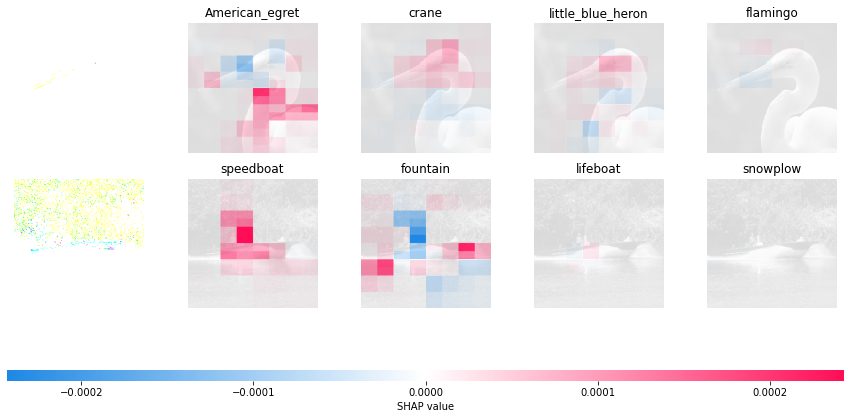

In [32]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
import shap
import tensorflow as tf

# load pre-trained model and choose two images to explain
model = ResNet50(weights='imagenet')
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)
X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values on four classes
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# use the image plot to display the output of SHAP values on each classes
shap.image_plot(shap_values)

In this visualization:

- Red pixels represent positive SHAP values that contributed to classifying that image as that particular class.
- Blue pixels represent negative SHAP values that contributed to not classifying that image as that particular class.


For example, in the speedboat class, the area that the SHAP values are positive is around the boat itself. Including the area where there are two people standing on the boat. So the machine classified that image as the speedboat.

## DeepExplainer

classshap.DeepExplainer(model, data, session=None, learning_phase_flags=None)
Meant to approximate SHAP values for deep learning models.

This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we approximate the conditional expectations of SHAP values using a selection of background samples. Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar, Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating over many backgound samples Deep estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

An explainer object for a differentiable model using a given background dataset.

Note that the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

Parameters:
modelif framework == ‘tensorflow’, (input
A pair of TensorFlow tensors (or a list and a tensor) that specifies the input and

output of the model to be explained. Note that SHAP values are specific to a single output value, so the output tf.Tensor should be a single dimensional output (,1).

if framework == ‘pytorch’, an nn.Module object (model), or a tuple (model, layer),
where both are nn.Module objects

The model is an nn.Module object which takes as input a tensor (or list of tensors) of shape data, and returns a single dimensional output. If the input is a tuple, the returned shap values will be for the input of the layer argument. layer must be a layer in the model, i.e. model.conv2

data :
if framework == ‘tensorflow’: [numpy.array] or [pandas.DataFrame] if framework == ‘pytorch’: [torch.tensor] The background dataset to use for integrating out features. Deep integrates over these samples. The data passed here must match the input tensors given in the first argument. Note that since these samples are integrated over for each sample you should only something like 100 or 1000 random background samples, not the whole training dataset.

if framework == ‘tensorflow’:
sessionNone or tensorflow.Session
The TensorFlow session that has the model we are explaining. If None is passed then we do our best to find the right session, first looking for a keras session, then falling back to the default TensorFlow session.

learning_phase_flagsNone or list of tensors
If you have your own custom learning phase flags pass them here. When explaining a prediction we need to ensure we are not in training mode, since this changes the behavior of ops like batch norm or dropout. If None is passed then we look for tensors in the graph that look like learning phase flags (this works for Keras models). Note that we assume all the flags should have a value of False during predictions (and hence explanations).

## GradientExplainer

classshap.GradientExplainer(model, data, session=None, batch_size=50, local_smoothing=0)
Explains a model using expected gradients (an extension of integrated gradients).

Expected gradients an extension of the integrated gradients method (Sundararajan et al. 2017), a feature attribution method designed for differentiable models based on an extension of Shapley values to infinite player games (Aumann-Shapley values). Integrated gradients values are a bit different from SHAP values, and require a single reference value to integrate from. As an adaptation to make them approximate SHAP values, expected gradients reformulates the integral as an expectation and combines that expectation with sampling reference values from the background dataset. This leads to a single combined expectation of gradients that converges to attributions that sum to the difference between the expected model output and the current output.

An explainer object for a differentiable model using a given background dataset.

Parameters:
modeltf.keras.Model, (input
(model, layer), where both are torch.nn.Module objects

For TensorFlow this can be a model object, or a pair of TensorFlow tensors (or a list and a tensor) that specifies the input and output of the model to be explained. Note that for TensowFlow 2 you must pass a tensorflow function, not a tuple of input/output tensors).

For PyTorch this can be a nn.Module object (model), or a tuple (model, layer), where both are nn.Module objects. The model is an nn.Module object which takes as input a tensor (or list of tensors) of shape data, and returns a single dimensional output. If the input is a tuple, the returned shap values will be for the input of the layer argument. layer must be a layer in the model, i.e. model.conv2.

data[numpy.array] or [pandas.DataFrame] or [torch.tensor]
The background dataset to use for integrating out features. Gradient explainer integrates over these samples. The data passed here must match the input tensors given in the first argument. Single element lists can be passed unwrapped.